**Томилов Матвей, 5130901/20103**

### *Упражнение 5.2.*

Необходимо создать функцию estimate_fundamental для отслеживания высоты тона записанного звука.

Написанная функция использует функцию autocorr из учебника. На полученных значениях мы выбираем промежуток и получаем максимальное значение, после чего переводим lag в частоту и возвращаем её.

Получившийся код представлен ниже:

In [84]:
def estimate_fundamental(wave, start, duration=0.01, low = 50, high = 150):
    segment = wave.segment(start=start, duration=duration)
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    return 1 / (lag / segment.framerate)


Спектрограмма записи вокального чирпа выглядит следующим образом:


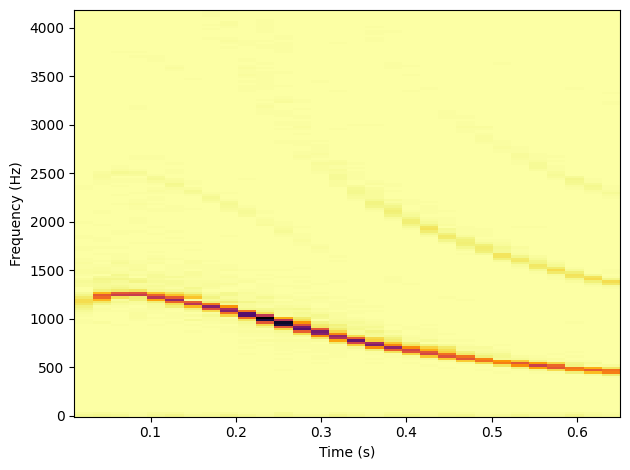

In [85]:
from matplotlib import pyplot as plt
from source_files.thinkdsp import read_wave, decorate
from source_files.autocorr import autocorr
import numpy as np

wave = read_wave('569028__gideonstar__lotus-flute-down.wav')

spectro = wave.make_spectrogram(seg_length=2048)
spectro.plot(high=4200)
decorate(xlabel='Time (s)',
        ylabel='Frequency (Hz)')
wave.make_audio()

Далее, с помощью написанной нами функции выведем график изменения основной частоты чирпа:

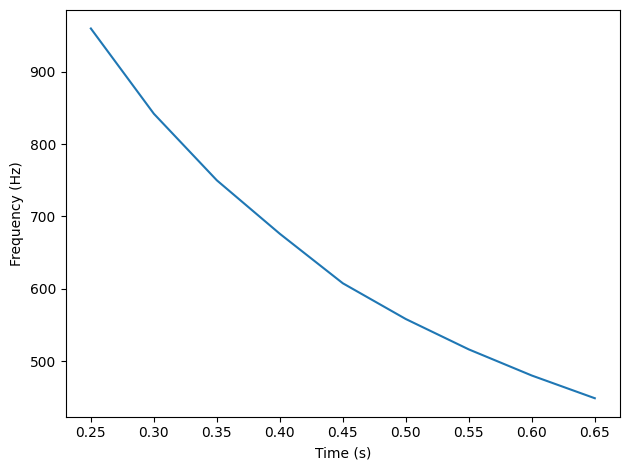

In [86]:
x = np.arange(0.25, wave.duration, 0.05)
y = [estimate_fundamental(wave, start) for start in x]
plt.plot(x, y)
decorate(xlabel='Time (s)',
        ylabel='Frequency (Hz)')

Исходя из полученного рисунка, частота меняется примерно с 950 до 450.

Чтобы убедиться в правильности расчётов, наложим этот график на спектрограмму, полученную выше.

Полученный результат выглядит так:

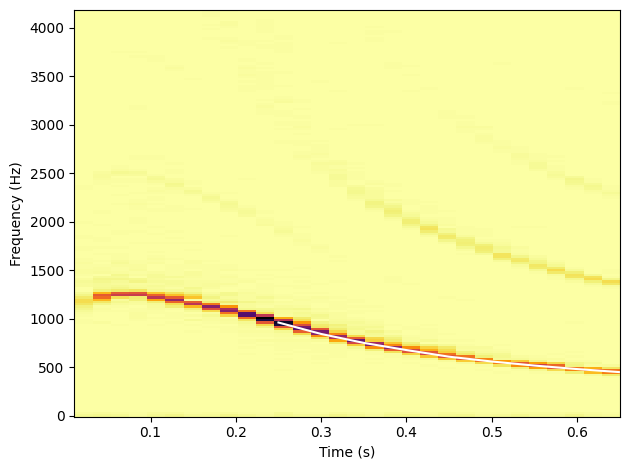

In [87]:
plt.plot(x, y, color='white')
spectro.plot(high=4200)
decorate(xlabel='Time (s)',
        ylabel='Frequency (Hz)')

Как и ожидалось, график изменения основной частоты чирпа наложился ровно на тёмную полосу спектрограммы, т. е. на самую высокую частоту.

### *Упражнение 5.3.*

Необходимо вычислить автокорреляции цен в платёжной системе BitCoin.

Выведем график изменения цен:

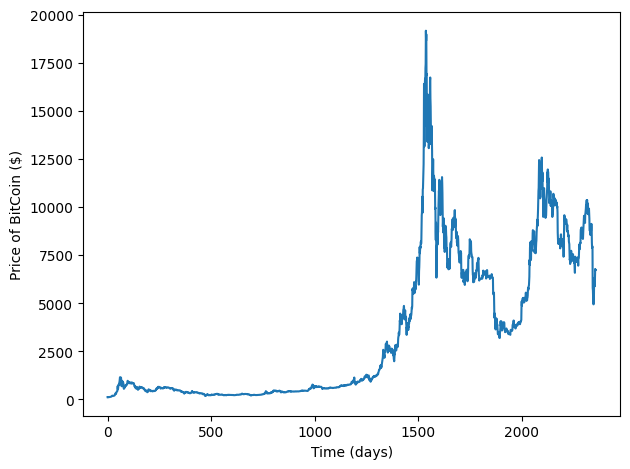

In [88]:
from matplotlib import pyplot as plt
from source_files.thinkdsp import decorate, Wave
from source_files.autocorr import autocorr
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv',
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index
wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

В предыдущей работе мы выяснили, что динамика изменения цен в данной таблице - это розовый шум.
Повторим анализ с использованием автокорреляции.

Получившийся график приведён ниже:

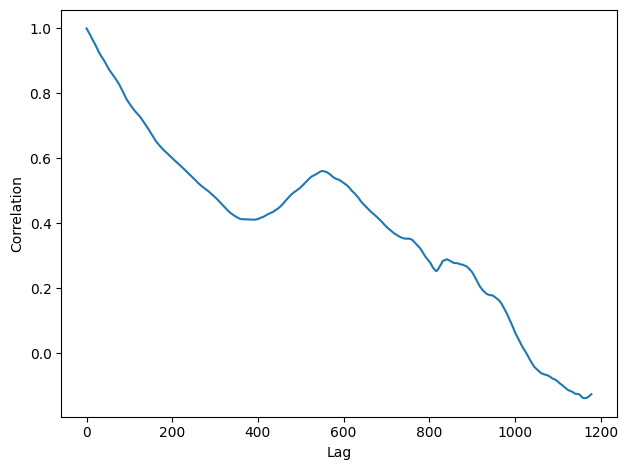

In [89]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

Как мы можем заметить, график не похож на график периодической функции и всё также напоминает розовый шум при β примерно равной 1.7, как и было установлено ранее.

### *Упражнение 5.4.*

Необходимо выполним анализ аудиозаписи саксофона для изучения явления «подавленная основная».

Воспроизведём запись саксофона:

In [90]:
from source_files.thinkdsp import read_wave, decorate, TriangleSignal
import numpy as np
from matplotlib import pyplot as plt

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.normalize()
wave.make_audio()

Теперь нам необходимо вывести спектрограмму полученного аудио.

Она выглядит так:

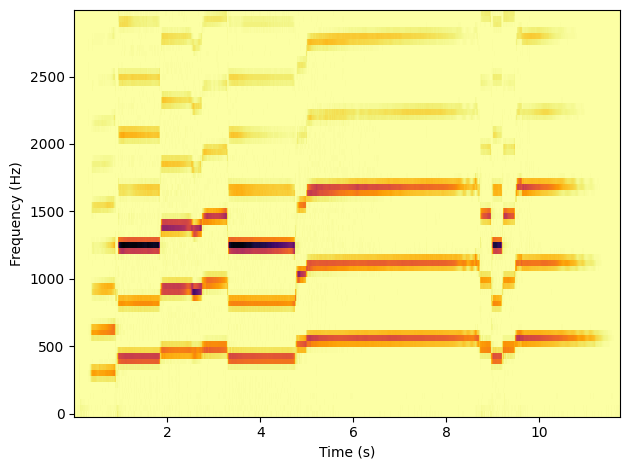

In [91]:
gram = wave.make_spectrogram(seg_length=1024)
gram.plot(high=3000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Для исследования возьмём отрезок, например, от 6 до 6.5 секунд:

In [92]:
start = 6.0
duration = 0.5
segment = wave.segment(start=start, duration=duration)
segment.make_audio()

Рассмотрим спектр выбранного отрезка.

Полученный гафик и значения частот представлены ниже:

[(np.float64(1815.189472282375), np.float64(1114.0)),
 (np.float64(1536.142223923965), np.float64(1670.0)),
 (np.float64(1337.2214321092208), np.float64(556.0)),
 (np.float64(1276.178380563102), np.float64(1672.0)),
 (np.float64(1274.2203137022836), np.float64(558.0)),
 (np.float64(706.3189084856052), np.float64(1668.0)),
 (np.float64(498.8761276414112), np.float64(554.0)),
 (np.float64(496.1139335893734), np.float64(2784.0)),
 (np.float64(375.34142701744923), np.float64(2786.0)),
 (np.float64(366.1734645584051), np.float64(560.0))]

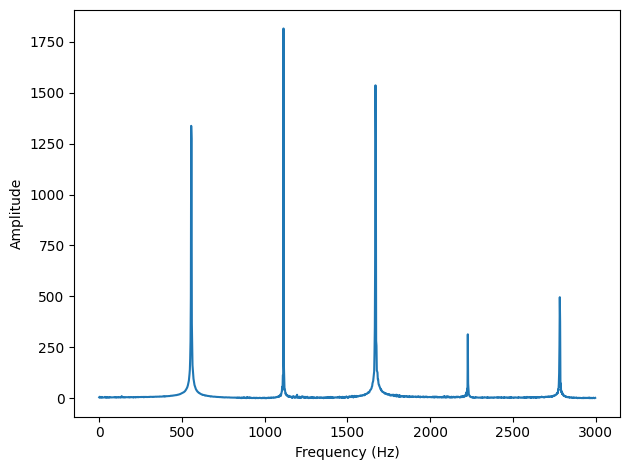

In [93]:
spectrum = segment.make_spectrum()
spectrum.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')
spectrum.peaks()[:10]

Как видно из графика, основные пики приходятся на частоты 466, 232, 234? Гц, но мы слышим лишь частоту 556 Гц.

Чтобы убедится в этом, прослушаем треугольный сигнал этой частоты:


In [94]:
TriangleSignal(freq=556).make_wave(duration=0.5).make_audio()

Мы правда слышим именно эту частоту.
Рассмотрим корреляцию заданного отрывка, чтобы понять почему так происходит.

Полученный график представлен ниже:

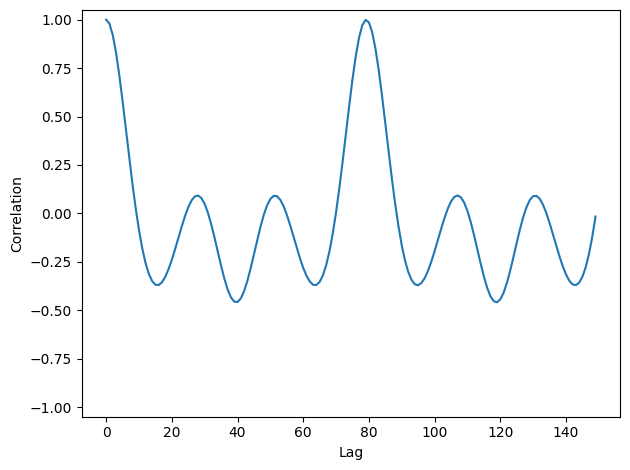

In [95]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

corrs = autocorr(segment)
plt.plot(corrs[:150])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

Пиковое значение lag находится около 80, для получения точного значения частоты напишем дополнительную функцию.

Результат её выведен ниже:

In [96]:
def find_frequency(corrs, low, high):
    lag = np.array(corrs[low:high]).argmax() + low
    print(lag)
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

find_frequency(corrs, 60, 100)

79


np.float64(558.2278481012657)

Полученное значение почти точно совпало с найденным ранее - 556 Гц, а отличие на 2 Гц может быть результатом погрешности.

Теперь мы можем сделать вывод о том, что основная частота, которую слышит человек, зависит от корреляции, а не от амплитуды на спектре.


Удалим найденный пик в 558 Гц - применим фильтр низких частот.

Получившийся график и аудиофайл:

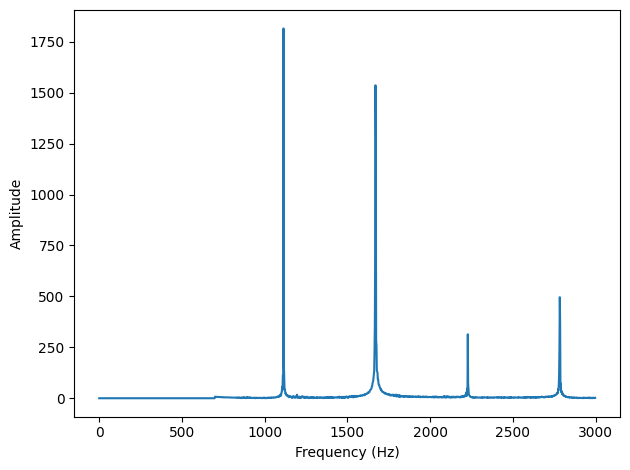

In [97]:
spectrum2 = segment.make_spectrum()
spectrum2.high_pass(700)
spectrum2.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')
segment2 = spectrum2.make_wave()
segment2.make_audio()

Звук стал заметно выше, но больше никак не изменился. С помощью функции корреляции попробуем выяснить, с чем это связано.

Новый график корреляции выглядит так:


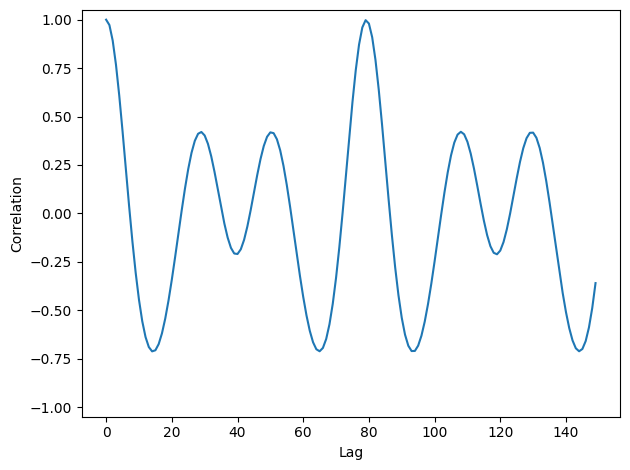

In [98]:
corrs = autocorr(segment2)
plt.plot(corrs[:150])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

После проведённой нами фильтрации пик на отметке lag около 80 остался.

Найдём точнные значения всех трёх пиков на графике.

Их значения приведены ниже:

In [99]:
find_frequency(corrs, 60, 100)

79


np.float64(558.2278481012657)

In [100]:
find_frequency(corrs, 20, 40)

29


np.float64(1520.6896551724137)

In [101]:
find_frequency(corrs, 40, 60)

50


np.float64(882.0)

Несмотря на то, что в спектре мы удалили пик 558 Гц, все еще самая большая частота на графике корреляции находится на этой отметке т. к. на высоких частотах преимущественно присутствуют гармоники именно этой частоты, а не 1520 и 882 Гц.


Чтобы убедиться, что причина кроется в этом, применим фильтр низких и высоких частот.

Получившийся спектр имеет следующий вид:


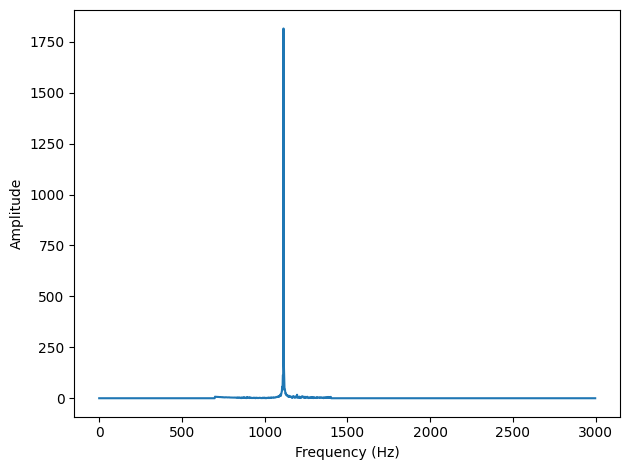

In [102]:
spectrum4 = segment.make_spectrum()
spectrum4.high_pass(700)
spectrum4.low_pass(1400)
spectrum4.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Выведем значение оставшегося пика:

In [103]:
spectrum4.peaks()[:5]

[(np.float64(1815.189472282375), np.float64(1114.0)),
 (np.float64(171.8397146012878), np.float64(1116.0)),
 (np.float64(118.36730603383192), np.float64(1112.0)),
 (np.float64(112.61442664484082), np.float64(1110.0)),
 (np.float64(101.466304054921), np.float64(1118.0))]

Итак, пик находится на частоте 1110-1118.

Сравним получившуюся аудиозапись с треугольным сигналом данной частоты:

In [104]:
segment4 = spectrum4.make_wave()
segment4.make_audio()

In [105]:
TriangleSignal(freq=1118).make_wave(duration=0.5).make_audio()

Звук стал намного выше исходного, а аудиозаписи на слух идентичны.

Необходимо снова вывести график корреляции полученного отрывка.

Теперь он выглядит так:


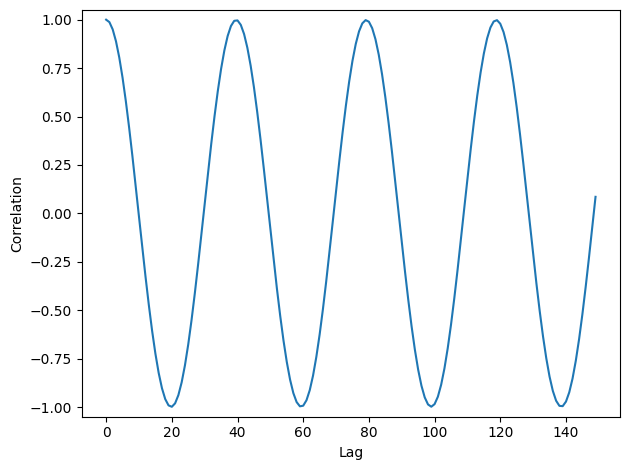

In [106]:
corrs = autocorr(segment4)
plt.plot(corrs[:150])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

После фильтрации на графике мы видим "ровный" периодический сигнал.

Выведем частоту первого пика:

In [107]:
find_frequency(corrs, 20, 60)

40


np.float64(1102.5)

Как и ожидалось, полученное значение частоты близко к тому, что мы получили на спектре. Этот факт подтверждает, что звук, который мы слышим, имеет частоту примерно 1110-1118 Гц.